# Double Image

After we saw [how a single image](./SingleImage.ipynb) is taken, we can create the second one.

In [15]:
import numpy as np

import synpivimage

In [16]:
cam = synpivimage.Camera(
    nx=256,
    ny=256,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=50,
    dark_noise=10,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=4  # px
)

laser = synpivimage.Laser(
    width=0.25,
    shape_factor=2
)

In [17]:
n = 100
particles = synpivimage.Particles(
    x=np.random.uniform(-3, cam.nx-1, n),
    y=np.random.uniform(-4, cam.ny-1, n),
    z=np.zeros(n),
    size=np.ones(n)*2,
)

## Take image

It is a simple as this: Just call `take_image` twice - but pass a new particle object to the second call. In this example, we will displace the particles by `dx=2.1` and `dy=3.4`.

**Note,** that we intentionally seeded the particles outside the camera sensor (`x=np.random.uniform(-3, cam.nx-1, n)`). This is done, so that these particles can move into the field of view (FOV). Otherwise, the particles (A) would leave the FOV.

In [18]:
imgA, partA = synpivimage.take_image(laser,
                                     cam,
                                     particles,
                                     particle_peak_count=1000)

displaced_particles = partA.displace(dx=2.1, dy=3.4)

imgB, partB = synpivimage.take_image(laser,
                                     cam,
                                     displaced_particles,
                                     particle_peak_count=1000)

In [19]:
import matplotlib.pyplot as plt

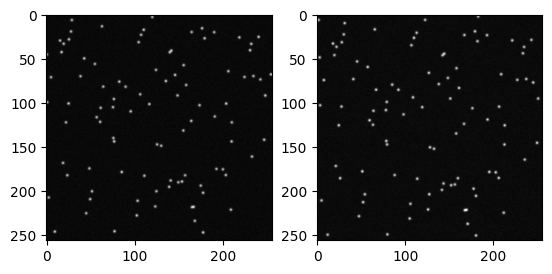

In [20]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(imgA, cmap='gray')
axs[1].imshow(imgB, cmap='gray')
plt.show()

## The problem of particle density (ppp)

The parameter `ppp` stands for particles per pixel and is an important parameter for PIV images. Until now, we always set the number of particles, which could have laid outside the FOV and would not have contributed to the ppp value.

The current ppp-values in image A and B are:

In [21]:
partA.get_ppp(cam.size), partB.get_ppp(cam.size)

(0.0014495849609375, 0.00146484375)

What we generally want to do, is to set a ppp-value in advance and figure out the needed number of particles. This approach is implemented. All you need to do is, to pass the expected min. and max. displacement in each axis direction x, y, and z.

For the above example and a ppp=0.1 this looks like this:

In [22]:
particles01 = synpivimage.Particles.generate(ppp=0.1, dx_max=[0, 2.1], dy_max=[0, 3.4], dz_max=[0, 0], camera=cam, laser=laser)
particles01.get_ppp(cam.size)

0.0999755859375

In [23]:
imgA, partA = synpivimage.take_image(laser,
                                     cam,
                                     particles01,  # we passed out new object here!
                                     particle_peak_count=1000)

displaced_particles = partA.displace(dx=2.1, dy=3.4)

imgB, partB = synpivimage.take_image(laser,
                                     cam,
                                     displaced_particles,
                                     particle_peak_count=1000)

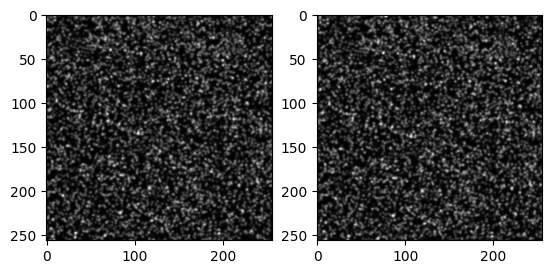

In [24]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(imgA, cmap='gray')
axs[1].imshow(imgB, cmap='gray')
plt.show()

Let's check the ppp for both image:

In [25]:
partA.get_ppp(cam.size), partB.get_ppp(cam.size)

(0.0999755859375, 0.1002349853515625)

**Note:** For small images, the second (B) may have a smaller or larger *ppp*. One single particle missing or not has a big influence. For larger images, the *ppp* will be almost the same for both images A and B.

## Save the double image(s)

To illustrate the image saving procedure, we will create multiple double images:

In [26]:
particles01 = synpivimage.Particles.generate(ppp=0.1, dx_max=[0, 2.1], dy_max=[0, 3.4], dz_max=[0, 0], camera=cam, laser=laser)


with synpivimage.Imwriter(case_name='double_images',
                          camera=cam,
                          laser=laser,
                          overwrite=True) as iw:
    for i in range(10):
        
        imgA, partA = synpivimage.take_image(
            laser,
            cam,
            particles01,  # we passed out new object here!
            particle_peak_count=1000)
    
        displaced_particles = partA.displace(dx=2.1, dy=3.4)
        
        imgB, partB = synpivimage.take_image(
            laser,                                 
            cam,
            displaced_particles,
            particle_peak_count=1000)

        iw.writeA(index=i, img=imgA, particles=partA)
        iw.writeB(index=i, img=imgB, particles=partB)

        particles01.regenerate()

In [27]:
import pathlib
import cv2

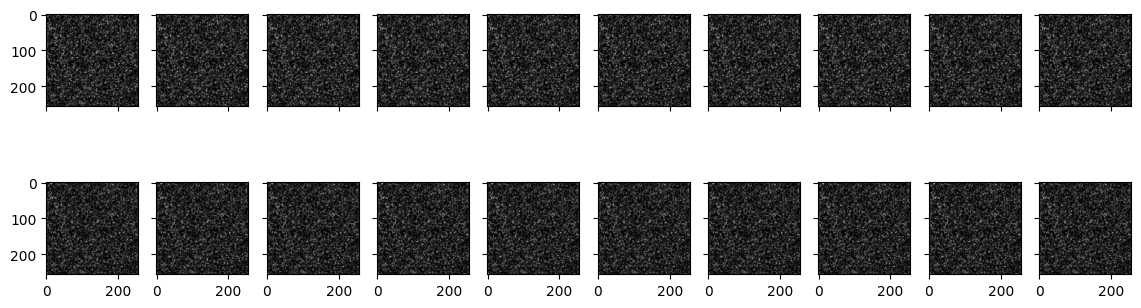

In [28]:
fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, 
                       figsize=(14, 4))

imgAfilenames = sorted(pathlib.Path('double_images/imgs/').glob('*A.tif'))
imgBfilenames = sorted(pathlib.Path('double_images/imgs/').glob('*B.tif'))
for i, (A, B) in enumerate(zip(imgAfilenames, imgBfilenames)):
    axs[0][i].imshow(cv2.imread(str(A), -1), cmap='gray')
    axs[1][i].imshow(cv2.imread(str(B), -1), cmap='gray')